# Computer Vision for IRES Images
### Berkay Dean

In [2]:
## Needed Libraries and Clear Vars
%reset -f
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sb
from ipywidgets import interactive
from random import shuffle
import os

ModuleNotFoundError: No module named 'pytables'

## Generalized functions 

In [9]:
## Jake's IRES Function
def vectorized_stride_v2(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size - 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0) .T
    )
    
    Mean = np.mean(array[sub_windows,0], +1)
    M = np.array([Mean])
   # M_norm = np.linalg.norm(M)
   # M = M/M_norm
    Var = np.var(array[sub_windows,0], +1)
    V = np.array([Var])
    #V_norm = np.linalg.norm(V)
   # V = V/V_norm
    St_Dev = np.std(array[sub_windows,0], +1)
    SD = np.array([St_Dev])
   # SD_norm = np.linalg.norm(SD)
   # SD = SD/SD_norm
    Skew = skew(array[sub_windows,0], +1)
    S = np.array([Skew])
    #S_norm = np.linalg.norm(S)
   # S = S/S_norm
    Kur =  kurtosis(array[sub_windows,0], +1)
    K = np.array([Kur])
   # K_norm = np.linalg.norm(K)
   # K = K/K_norm
    m = np.concatenate([M, V, SD, S, K])
    for i in range (len(m)):
        offset = [min(m[i])] * len(m[i])
        m[i] = (m[i]-offset)
        norm = [max(m[i])]*len(m[i])
        m[i] = m[i]/norm
    m = m .T
    return  m

## IRES Image Creation
The following code creates the IRES Images that will be used in the computer vision model

KeyboardInterrupt: 

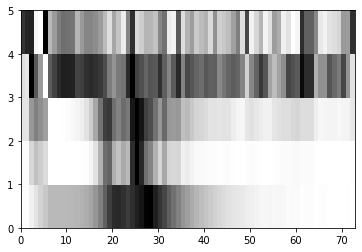

In [10]:
filenames = sorted(glob.glob('G:\Shared drives\Research Simulation Data\\NPN sim\LM124_sim_SET2_*.sorted')) #change file name  
filenames = filenames[0:400]
i = 0; # number for storing images in dataset folder
for filename in filenames:
    D = np.loadtxt(fname=filename,dtype=np.float64)
    cols = ["val", "time", "vout", "vin"]
    df = pd.DataFrame(D,columns=cols)
    y = df[['vout']]
    max_val = max(df['val'])
    max_val = int(max_val)
    df = df.drop(columns=['vin', 'time', 'val'])
    df = df.to_numpy()
    b = vectorized_stride_v2(df, 0, max_val, 5, 1)

#def plotting (sub_window_size = 10000, stride_size = 1000):    
    #b = np.array(b)
    #print(b)
    cols = ['MEAN', 'VARIANCE', 'STANDARD DEV', 'SKEWNESS', 'KURTOSIS']
    dk = pd.DataFrame(b, columns=cols)
    #print(dk)
    #dk = dk.to_numpy()
    #grid = dict(width_ratios=[30,1],height_ratios=[5,1])
    #fig,ax = plt.subplots(2,2,gridspec_kw=grid)
    #cm = ax[0][0].pcolor(dk.T, cmap = 'rainbow')
    cm = plt.pcolor(dk.T, cmap = 'binary')
    
    #ax[1][0].plot(y)
    #ax[1][0].margins(x=0)
    #ax[1][1].axis('off')
    #ax[0][0].set_yticks(range(len(dk.columns)))
    #ax[0][0].set_yticklabels(dk.columns)
    #ax[0][0].set_title(filename)
    #plt.colorbar(cm,cax=ax[0][1],ax=ax[0][0])
    #plt.show()

    ## saves each image to subdirectory
    plt.savefig('IRES_Images/ires_{0}.jpg'.format(i))
    i+=1


## Image Pre-Processing

In [14]:
## load in images
images = [cv2.imread(file, cv2.COLOR_BGR2GRAY) for file in glob.glob(r'IRES_Images\ires_*.jpg')]

## scaling params
scale_percent = 50 # percent of original size
width = int(images[0].shape[1] * scale_percent / 100)
height = int(images[0].shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized_images = [cv2.resize(image, dim, interpolation = cv2.INTER_AREA) for image in images]

print('Original Dimensions : ',images[0].shape)
print('Resized Dimensions : ',resized_images[0].shape)

Original Dimensions :  (288, 432, 3)
Resized Dimensions :  (144, 216, 3)


## File Formatting and Organization

In [ ]:
## format file appropriately (use medium tutorial)
shuffle_data = True  # shuffle the addresses before saving
dirname = os.path.dirname(__file__)  ## path to current working directory
hdf5_path =  os.path.join(dirname, 'IRES_Images/dataset.hdf5')  # address to where you want to save the hdf5 file
filepath_train = os.path.join(dirname, 'IRES_Images/*') ## join paths, path of the directory where image data is stored.
data_order = 'tf' # different library uses different data ordering `tf` is used for tensor flow.

## Convolutional Neural Network